# Autophagy multi-class classifier (2)

<b> What is our goal now? <b>

The main goal is to develop a model that has meaningful uncertainty, meaning the uncertainty is low for known and biologically uninteresting classes, but high for unknown and ideally biologically interesting classes.
The way to test this for the multi-class classifier is by leaving out different biological conditions during training and then checking uncertainty on them.

<b> What are we doing in this section? <b>

1. Read in and briefly investigate the new data
2. Rotate train and test data groups while checking the uncertainty
3. Turn binary clasifier into a multi-class classifier by doing the following:
* modify model output layer to e.g. softmax from sigmoid
* use Cross Entropy loss (as already done actually...)
* update ground truth labels to represent the class indices instead of binary values
* potentially update evaluation metrics and data loader and specificy number of classes as variable


<b> What data do we have now? <b>

We now have image data on:
1. Stimulated 14h (or 16h)
2. Unstimulated
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data])
4. Stimulated timecourse data
5. EI24 KO timecourse data

We can think of timeseries as follows: 1h unstim -> more and more vesicle formation -> 15h stimulated. Btw, EI24 (EI24 Autophagy Associated Transmembrane Protein) is a gene which induces apoptosis. 

Data can be found here:

* (1. - 4.) has already been loaded and used before
* Screen single cell images from 6 different slides are here: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/
* Three replicates of single cell image EI24 KO timecourse data are now in /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix

Description of the EI24KO HDF5 files:

These files contain information about cells recorded at different timepoints, however the cells are fixed at each timepoint so we don’t have single cell information across timepoints. For the EI24 KO the last timepoint would be most relevant.

-> Keys: <KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>

* label_names describes the columns of single_cell_index_labelled
* single_cell_data contains the single cell images with the same five channels as always
* single_cell_index two column table of indexed cell ids.
* single_cell_index_labelled information about each cell [b'index', b'cellid', b'ID', b'location', b'timepoint', b'well', b'region', b'Genotype', b'Condition']

## Notebook overview

* [I. Read in new data and create data object HDF5SingleCellDataset](#vis)
* [II. Train multi-class classifier and monitor performance with wandb](#multi)     

## I Read in new data and create data object HDF5SingleCellDataset  <a class="anchor" id="vis"></a>

In [1]:
import h5py
import matplotlib.pyplot as plt

num_channels = 5

channel_info = {
    1: "mask nucleus",
    2: "mask cytosol",
    3: "img nucleus",
    4: "img membrane",
    5: "img LC3"
}

In [2]:
#stimulates timeseries 6 slides
stim_timeseries_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5"
stim_timeseries_hdf5 = h5py.File(stim_timeseries_hdf5_path, "r")
stim_timeseries_hdf5.keys()

<KeysViewHDF5 ['single_cell_data', 'single_cell_index']>

In [8]:
stim_imeseries_index_hdf5 = stim_timeseries_hdf5["single_cell_index"][:]
stim_timeseries_cells_hdf5 = stim_timeseries_hdf5["single_cell_data"][0:100, :]

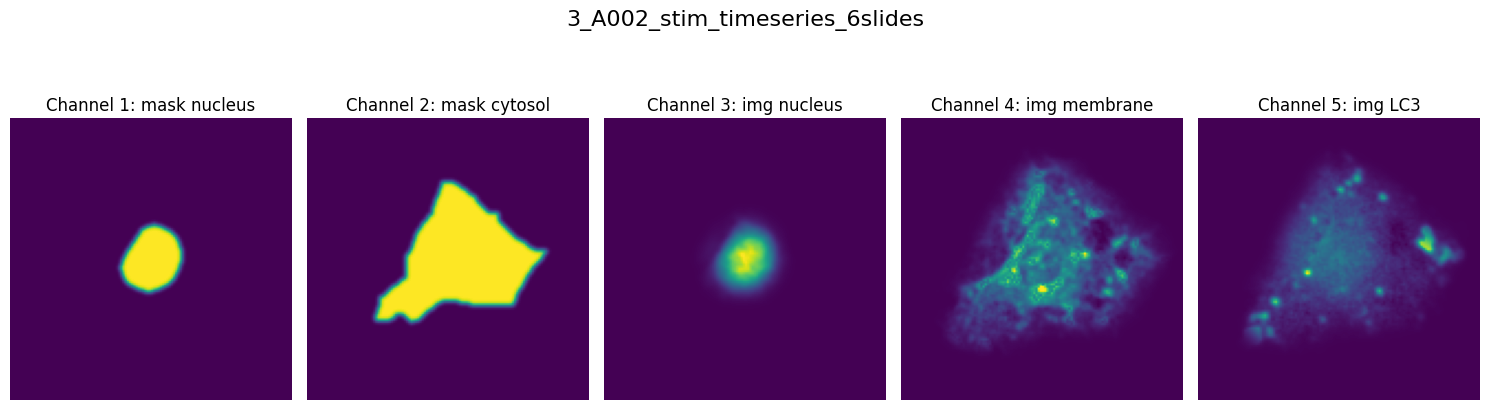

In [9]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(stim_timeseries_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Add title
main_title = "3_A002_stim_timeseries_6slides"
plt.suptitle(main_title, fontsize=16, y=1.)

# Show the plot
plt.show()

In [5]:
# El24 KO timecourse
El24_KO_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5"
El24_KO_hdf5 = h5py.File(El24_KO_hdf5_path, "r")
El24_KO_hdf5.keys()

<KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>

In [6]:
El24_KO_timeseries_index_hdf5 = El24_KO_hdf5["single_cell_index"][:]
El24_KO_timeseries_cells_hdf5 = El24_KO_hdf5["single_cell_data"][0:100, :]

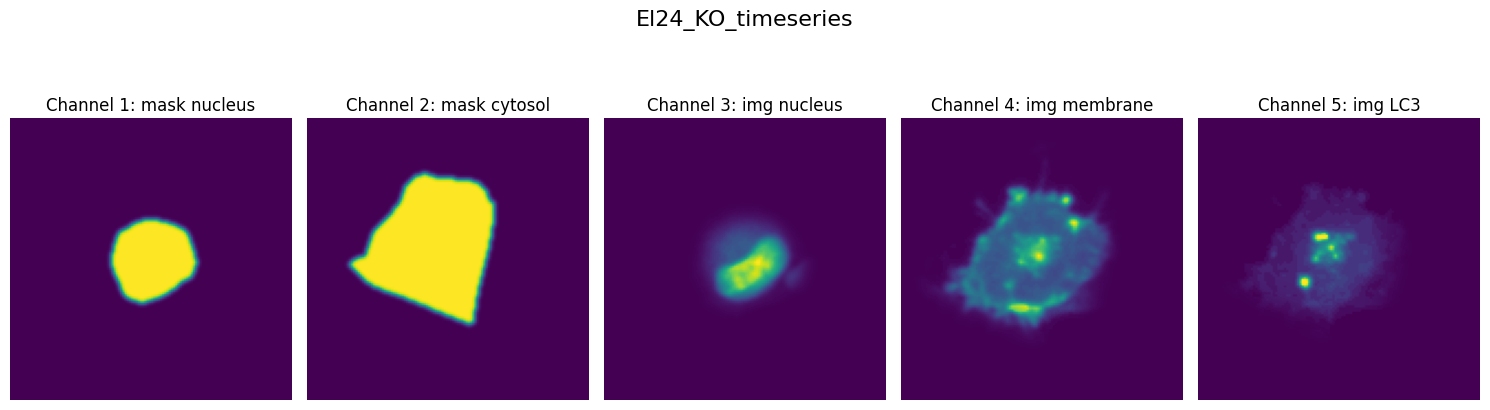

In [7]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(El24_KO_timeseries_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Add title
main_title = "El24_KO_timeseries"
plt.suptitle(main_title, fontsize=16, y=1.)

# Show the plot
plt.show()

## II.  Train multi-class classifier and monitor performance with wandb <a class="anchor" id="multi"></a>

In [1]:
import os
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

from sparcscore.ml.datasets import HDF5SingleCellDataset
#from sparcscore.pipeline.project import TimecourseProject, Project
#from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

NOTE! Installing ujson may make loading annotations faster.


### Binary VGG-like classifier from SPARCSpy -> multi-class classifier with same architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        
        # VGG-like feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier head for multi-class
        self.fc_input_size = 8192  # Adjusted based on the size of x
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096),  # You can adjust these dimensions as needed
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)  # Adjust the output size for multi-class
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        # Print the size of x to confirm it's correct
        #print("Size of x:", x.size())
        
        x = self.classifier(x)
        return x

# Create an instance of the model
num_classes = 5  # Replace with the actual number of classes
model = MultiClassClassifier(num_classes)
print(model)

MultiClassClassifier(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (

We specifically want the following scenarios:

train | test

* 1,3 | 2 [Case 1]
* 1,3 | 4 [Case 2]
* 1,3 | 5 [Case 3]
* 1,2,3 | 4 [Case 4]
* 1,2,3 | 5 [Case 5]
* 1,2,3,4 | 5 (advantage is that 4 and 5 have a batch effect vs the others that can be learned by including 4. use only final timepoint of 4?) [Case 6]

Note: 1,2 and 3 are the biological classes we had in the first Autophagy (1) notebook.

We set labels as follows in our following hdf5 data objects: 

* Stimulated 14h (or 16h) -> (1)
* Unstimulated -> (2)
* ATG5 KO -> (3)
* Stimulated timecourse -> (4)
* EI24 KO timecourse data -> (5)

### Case 1.5 (use 2,3 for training, and 1 for testing)

In [3]:
case1_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',  
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5'],
    dir_labels=[2, 2, 2, 2, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 500000
1: 100000
2: 400000


In [4]:
case1_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
             ],
    dir_labels=[0, 0, 0, 0, 0, 1, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 700000
0: 500000
1: 100000
2: 100000


### Run multi-class classifier on case 1.5

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import sys

# Redirect print statements to a file
sys.stdout = open("autophagy_multi_class_output.txt", "w")

# Log into W&B
wandb.login()

# Start a W&B Run
run = wandb.init(project="VGG2_autophagy_multi_class_training")

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the Multi-Class Classifier model on the selected device
num_classes = 3
model = MultiClassClassifier(num_classes)
model.to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # number of training epochs
batch_size = 256  # batch size
log_interval = 50  # Log metrics every 50 batches

# Set train and test data based on the scenario
train_data = case1_hdf5_train_data
test_data = case1_hdf5_test_data

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

stop_training = False

for epoch in range(1, num_epochs + 1):
    if stop_training:
        break  # Stop training if accuracy reaches 98.0%

    print("Epoch: ", epoch)
    model.train()  # Set the model to training mode

    total_loss = 0.0
    correct = 0

    total_samples = len(train_data)

    batch_counter = 0  # Reset batch counter at the start of each epoch

    for batch_idx, (data, labels) in enumerate(train_data_loader):
        print("Current batch: " + str(batch_idx))
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        output = model(data)  # Forward pass
        loss = loss_function(output, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.sum().item()
        _, predicted = output.max(1)
        correct += predicted.eq(labels).sum().item()

        batch_counter += 1

        # Calculate accuracy and average loss for the current batch
        accuracy = 100.0 * correct / (batch_counter * batch_size)
        average_loss = total_loss / (batch_counter * batch_size)

        # Check for the desired accuracy and stop training if reached
        if accuracy >= 98.0:
            stop_training = True
            break

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p)) for p in probs]

        # Store uncertainties for each class
        all_class_uncertainties = []
        for i in range(num_classes):
            class_uncertainty = uncertainties[i].detach().cpu().numpy()
            all_class_uncertainties.append(class_uncertainty)

    # Calculate precision, recall, and F1-score for the entire training dataset at the end of the epoch
    all_train_labels = []
    all_train_predicted = []

    for data, labels in train_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predicted.extend(predicted.cpu().numpy())

    train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

    print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
    print("Train Accuracy: {:.2f}%".format(train_accuracy))
    
    # Log train metrics for the epoch, including accuracy and loss
    wandb.log({
        "Train Epoch": epoch,
        "Train_Precision": train_precision,
        "Train_Recall": train_recall,
        "Train_F1-score": train_f1,
        "Train_Accuracy": train_accuracy,
        "Train_Loss": average_loss,
    })

    # Reset correct and total_loss at the beginning of each epoch
    correct = 0
    total_loss = 0.0

    # Evaluate the model on the test set after each epoch
    model.eval()
    test_correct = 0
    test_total_samples = len(test_data)
    test_average_loss = 0.0
    test_batch_counter = 0
    all_test_labels = []
    all_test_predicted = []

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        test_correct += predicted.eq(labels).sum().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

        loss = loss_function(output, labels)
        test_average_loss += loss.sum().item()
        test_batch_counter += 1

        # Calculate accuracy for the current test batch
        test_accuracy = 100.0 * test_correct / (test_batch_counter * batch_size)

        # Log test metrics for every 100 test batches
        if test_batch_counter % log_interval == 0:
            test_average_loss /= log_interval
            print("Test Accuracy: {:.2f}% Test Loss: {:.4f}".format(test_accuracy, test_average_loss))

            test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
            test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
            test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')

            # Log test metrics for every 100 test batches
            wandb.log({
                "Test Epoch": epoch,
                "Test_Batch": test_batch_counter,
                "Test_Loss": test_average_loss,
                "Test_Accuracy": test_accuracy,
                "Test_Precision": test_precision,
                "Test_Recall": test_recall,
                "Test_F1-score": test_f1,
            })
            test_average_loss = 0.0

    # Calculate precision, recall, and F1-score for the entire test dataset at the end of the epoch
    test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')
    
    # Log test metrics for the entire test dataset at the end of the epoch
    wandb.log({
        "Test Epoch": epoch,
        "Test_Precision": test_precision,
        "Test_Recall": test_recall,
        "Test_F1-score": test_f1,
    })

    # Calculate and write class uncertainties for the entire test dataset to a file
    test_class_uncertainties = [[] for _ in range(num_classes)]  # Initialize uncertainties for each class

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p)) for p in probs]

        # Store uncertainties for each class
        for i in range(num_classes):
            class_uncertainty = np.mean(uncertainties[i].detach().cpu().numpy())
            test_class_uncertainties[i].extend([class_uncertainty])

    # Save class uncertainties to a file
    with open(f'class_uncertainties_epoch{epoch}.txt', 'w') as f:
        for i in range(num_classes):
            f.write(f'Class {i} Uncertainty: {np.mean(test_class_uncertainties[i])}\n')

# Save model
torch.save(model.state_dict(), 'multi_class_VGG2_case1.pth')

# Close the W&B run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marunku (crisprscreen). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Test Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
Test_Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Batch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Test_F1-score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Loss,▃▃▃▃▃▃▃▄███████▁▁▁▁▁▁▁▂▇▇▇▇▇▇▇
Test_Precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Epoch,▁█
Train_Accuracy,▁█
Train_F1-score,▁█
Train_Loss,█▁


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import numpy as np
import sys

# Redirect print statements to a file
sys.stdout = open("autophagy_multi_class_output.txt", "w")

# Log into W&B
wandb.login()

# Start a W&B Run
run = wandb.init(project="VGG2_autophagy_multi_class_training")

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the Multi-Class Classifier model on the selected device
num_classes = 3
model = MultiClassClassifier(num_classes)
model.to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # number of training epochs
batch_size = 256  # batch size
log_interval = 50  # Log metrics every 50 batches

epsilon = 1e-8  # Small epsilon value to prevent log(0) in uncertainties

# Set train and test data based on the scenario
train_data = case1_hdf5_train_data
test_data = case1_hdf5_test_data

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

stop_training = False

for epoch in range(1, num_epochs + 1):
    if stop_training:
        break  
    
    print("Epoch: ", epoch)
    model.train()  # Set the model to training mode

    total_loss = 0.0
    correct = 0
    total_samples = len(train_data)
    batch_counter = 0  # Reset batch counter at the start of each epoch

    for batch_idx, (data, labels) in enumerate(train_data_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        output = model(data)  # Forward pass
        loss = loss_function(output, labels)  # Calculate the losss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.sum().item()
        _, predicted = output.max(1)
        correct += predicted.eq(labels).sum().item()

        batch_counter += 1
        
        # Calculate accuracy and average loss for the current batch
        accuracy = 100.0 * correct / (batch_counter * batch_size)
        average_loss = total_loss / (batch_counter * batch_size)

        # Check for the desired accuracy and stop training if reached
        if accuracy >= 95.0:
            stop_training = True
            print("Accuracy over 95% reached and thus stopping training...")
            break

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p + epsilon)) for p in probs]

        # Store uncertainties for each class
        all_class_uncertainties = []
        for i in range(num_classes):
            class_uncertainty = uncertainties[i].detach().cpu().numpy()
            all_class_uncertainties.append(class_uncertainty)

    # Calculate precision, recall, and F1-score for the entire training dataset at the end of the epoch
    all_train_labels = []
    all_train_predicted = []

    for data, labels in train_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predicted.extend(predicted.cpu().numpy())

    train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')
    train_balanced_accuracy = balanced_accuracy_score(all_train_labels, all_train_predicted)

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

    print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
    print("Train Balanced Accuracy: {:.2f}%".format(train_balanced_accuracy))
    
    # Log train metrics for the epoch, including accuracy and loss
    wandb.log({
        "Train Epoch": epoch,
        "Train_Precision": train_precision,
        "Train_Recall": train_recall,
        "Train_F1-score": train_f1,
        "Train_Balanced_Accuracy": train_balanced_accuracy,
        "Train_Loss": average_loss,
    })

    # Reset correct and total_loss at the beginning of each epoch
    correct = 0
    total_loss = 0.0

    # Evaluate the model on the test set after each epoch
    model.eval()
    test_correct = 0
    test_average_loss = 0.0
    test_batch_counter = 0
    all_test_labels = []
    all_test_predicted = []

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        test_correct += predicted.eq(labels).sum().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

        loss = loss_function(output, labels)
        test_average_loss += loss.sum().item()
        test_batch_counter += 1

    # Calculate and write class uncertainties for the entire test dataset to a file
    test_class_uncertainties = [[] for _ in range(num_classes)]  # Initialize 

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)

        # Calculate class probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Calculate uncertainties (entropy) for each class
        uncertainties = [-torch.sum(p * torch.log(p + epsilon)) for p in probs]

        # Store uncertainties for each class
        for i in range(num_classes):
            class_uncertainty = np.mean(uncertainties[i].detach().cpu().numpy())
            test_class_uncertainties[i].extend([class_uncertainty])

    # Save class uncertainties to a file
    print("Writing to file now...")
    with open(f'case_2_class_uncertainties_epoch{epoch}.txt', 'w') as f:
        for i in range(num_classes):
            f.write(f'Class {i} Uncertainty: {np.mean(test_class_uncertainties[i])}\n')
            
    # Plot histogram of uncertainties for class 1
    class1_uncertainties = test_class_uncertainties[1]
    plt.hist(class1_uncertainties, bins=50, alpha=0.5, color='blue', label='Class 1 Uncertainties')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Uncertainty Distribution for Class 1')
    plt.legend()
    plt.savefig(f'case_2_uncertainty_histogram_class1_epoch{epoch}.png')
    plt.close()

    # Calculate confusion matrix and performance metrics for class 2
    true_labels = all_test_labels  # These are all class 2
    predicted_labels = all_test_predicted

    confusion = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(confusion)
    with open("case2__confusion_matrix.txt", "w") as f:
        f.write("Confusion Matrix:\n")
        f.write(np.array2string(confusion, separator=', '))

# Save model
print("Saving final model now...")
torch.save(model.state_dict(), 'multi_class_VGG2_case2.pth')

# Close the W&B run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marunku (crisprscreen). Use `wandb login --relogin` to force relogin


This code calculates and logs uncertainties for each class by computing the entropy of class probabilities and stores these values in separate logs with class-specific names. This way, we can analyze uncertainties for each class individually.

### Case 2 (use 1,3 for training, and 4 for testing)

In [10]:
case2_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5'],
    dir_labels=[3, 1, 3, 1, 3, 1, 3, 1, 3, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1000000
1: 500000
3: 500000


In [11]:
case2_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 2393091
4: 2393091


### Case 3 (use 1,3 for training, and 5 for testing)

In [12]:
case3_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5'],
    dir_labels=[3, 1, 3, 1, 3, 1, 3, 1, 3, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1000000
1: 500000
3: 500000


In [13]:
case3_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/single_cells.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/single_cells.h5'],
    dir_labels=[5, 5, 5], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 135131
5: 135131


### Case 4 (use 1,2,3 for training, and 4 for testing)

In [14]:
case4_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5'],
    dir_labels=[3, 1, 3, 2, 1, 3, 2, 1, 3, 1, 3, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1200000
1: 500000
2: 200000
3: 500000


In [16]:
case4_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 2393091
4: 2393091


### Case 5 (use 1,2,3 for training, and 5 for testing)

In [15]:
case5_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5'],
    dir_labels=[3, 1, 3, 2, 1, 3, 2, 1, 3, 1, 3, 1], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1200000
1: 500000
2: 200000
3: 500000


In [17]:
case5_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/single_cells.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/single_cells.h5'],
    dir_labels=[5, 5, 5], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 135131
5: 135131


### Case 6 (use 1,2,3,4 for training, and 5 for testing)

In [20]:
case6_hdf5_train_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5'],
    dir_labels=[4, 3, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 1, 3, 4, 1, 4], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3593091
1: 500000
2: 200000
3: 500000
4: 2393091


In [18]:
case6_hdf5_test_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/single_cells.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/single_cells.h5'],
    dir_labels=[5, 5, 5], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 135131
5: 135131
